# "Improving reservoirs using intrinsic plasticity"

Benjamin Schrauwen, Marion Wardermann, David Verstraeten, Jochen J. Steil, Dirk Stroobandt

*Neurocomputing*, 71(7), 1159–1171, 2008, https://doi.org/10.1016/j.neucom.2007.12.020

*See also:*

Triesch, J. (2005). A Gradient Rule for the Plasticity of a Neuron’s Intrinsic Excitability. In W. Duch, J. Kacprzyk, E. Oja, & S. Zadrożny (Eds.), *Artificial Neural Networks: Biological Inspirations – ICANN 2005* (pp. 65–70). Springer. https://doi.org/10.1007/11550822_11

In [1]:
import reservoirpy as rpy
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import narma
from reservoirpy.mat_gen import uniform, bernoulli
from reservoirpy.nodes import IPReservoir

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

rpy.verbosity(0)
rpy.set_seed(123456789)

## Authors abstract

"The beneﬁts of using intrinsic plasticity (IP), an unsupervised, local, biologically inspired adaptation rule that tunes the probability
density of a neuron’s output towards an exponential distribution—thereby realizing an information maximization—have already been
demonstrated. In this work, we extend the ideas of this adaptation method to a more commonly used non-linearity and a Gaussian
output distribution. After deriving the learning rules, we show the effects of the bounded output of the transfer function on the moments
of the actual output distribution. This allows us to show that the rule converges to the expected distributions, even in random recurrent
networks. The IP rule is evaluated in a reservoir computing setting, which is a temporal processing technique which uses random,
untrained recurrent networks as excitable media, where the network’s state is fed to a linear regressor used to calculate the desired
output. We present an experimental comparison of the different IP rules on three benchmark tasks with different characteristics.
Furthermore, we show that this unsupervised reservoir adaptation is able to adapt networks with very constrained topologies, such as a
1D lattice which generally shows quite unsuitable dynamic behavior, to a reservoir that can be used to solve complex tasks. We clearly
demonstrate that IP is able to make reservoir computing more robust: the internal dynamics can autonomously tune themselves—
irrespective of initial weights or input scaling—to the dynamic regime which is optimal for a given task."


## Implementation using ReservoirPy

This notebook is provided as a demo of the `IPReservoir` node in ReservoirPy, implementing the method described in the paper *Improving reservoirs using intrinsic plasticity* by Schrauwen et al.

`IPReservoir` allows to train intrinsic plasticity parameters in an unsupervised way, as first described by Triesch in his paper *A Gradient Rule for the Plasticity of a Neuron’s Intrinsic Excitability*. These parameters are stored in the reservoir as `a` and `b`, two attributes of the object.

`IPReservoir` forward function is defined as:

$$
\mathbf{s}[t+1] = lr * \mathbf{s}[t] + (1 - lr) * (\mathbf{W}\mathbf{x}[t] + \mathbf{W}_{in}\mathbf{u}[t+1] + \mathbf{W}_{fb}\mathbf{y}[t]) 
$$
$$
\mathbf{x}[t+1] = f(\mathbf{a}*\mathbf{s}[t+1] + \mathbf{b})
$$

Where:
- $\mathbf{s}$ is the reservoir internal state (before activation);
- $\mathbf{x}$ is the reservoir activation;
- $lr$ is the leaking rate;
- $\mathbf{u}$ is the input vector;
- $\mathbf{y}$ is the feedback vector (optional);
- $\mathbf{W}$ is the recurrent weight matrix;
- $\mathbf{W}_{in}$ is the input weight matrix;
- $\mathbf{W}_{fb}$ is the feedback weight matrix (optional);
- $f$ is either hyperbolic tangent or sigmoid function;
- $\mathbf{a}$ and $\mathbf{b}$ are intrinsic plasticity parameters (gain and bias).


In [2]:
def heavyside(x):
    return 1.0 if x >= 0 else 0.0

def bounded(dist, x, mu, sigma, a, b):
    """Return the bounded version of a scipy.stats distribution.
    
    As described in the paper (section 2.1)"""
    num = dist.pdf(x, loc=mu, scale=sigma) * heavyside(x - a) * heavyside(b - x)
    den = dist.cdf(b, loc=mu, scale=sigma) - dist.cdf(a, loc=mu, scale=sigma)
    return num / den

## Intrinsic Plasticity for NARMA timeseries

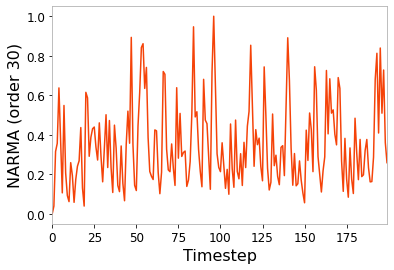

In [3]:
steps = 1000
X = narma(steps)
X = (X - X.min()) / (X.ptp())

plt.plot(X[:200])
plt.ylabel("NARMA (order 30)")
plt.xlabel("Timestep")
plt.show()

### Using sigmoid activation function

As demonstrated in the paper, the most effective reservoir activation distribution for neurons equiped with a sigmoid activation function an exponential distribution of parameter $\mu$.

In [4]:
# Parameters (from the paper)
activation = "sigmoid"
units = 100
connectivity = 0.1
sr = 0.95
input_scaling = 0.1
mu = 0.3
warmup = 100
learning_rate = 5e-4
epochs = 100
W_dist = uniform(high=1.0, low=-1.0)
Win_dist = bernoulli

In [5]:
reservoir = IPReservoir(
    units,
    sr=sr,
    mu=mu,
    learning_rate=learning_rate,
    input_scaling=input_scaling,
    W=W_dist,
    Win=Win_dist,
    rc_connectivity=connectivity,
    input_connectivity=connectivity,
    activation=activation,
    epochs=epochs
)

In [6]:
reservoir = reservoir.fit(X, warmup=warmup)

In [7]:
# Resetting and warming up
reservoir.run(X[:warmup], reset=True)

# Running
states = reservoir.run(X[warmup:])

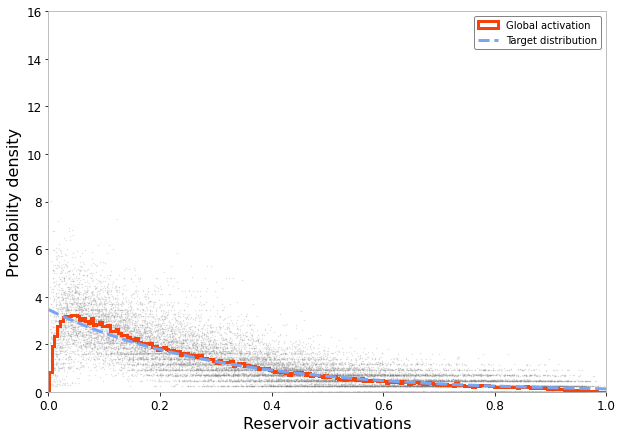

In [8]:
from scipy.stats import expon

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0, 16)
for s in range(states.shape[1]):
    hist, edges = np.histogram(states[:, s], density=True, bins=200)
    points = [np.mean([edges[i], edges[i+1]]) for i in range(len(edges) - 1)]
    ax1.scatter(points, hist, s=0.2, color="gray", alpha=0.25)
ax1.hist(states.flatten(), density=True, bins=200, histtype="step", label="Global activation", lw=3.0)

x = np.linspace(0.0, 1.0, 200)
pdf = [bounded(expon, xi, 0.0, mu, 0.0, 1.0) for xi in x]
ax1.plot(x, pdf, label="Target distribution", linestyle="--", lw=3.0)

ax1.set_xlabel("Reservoir activations")
ax1.set_ylabel("Probability density")
plt.legend()
plt.show()

### Using hyperbolic tangent activation function

As demonstrated in the paper, the most effective reservoir activation distribution for neurons equiped with a hyperbolic tangent activation function a Gaussian distribution of parameter $\mu=0$, $\sigma$.

In [9]:
# Parameters (from the paper)
activation = "tanh"
units = 100
connectivity = 0.1
sr = 0.95
input_scaling = 0.1
mu = 0.0
sigma = 0.1
warmup = 100
learning_rate = 5e-4
epochs = 100
W_dist = uniform(high=1.0, low=-1.0)
Win_dist = bernoulli

In [10]:
reservoir = IPReservoir(
    units,
    sr=sr,
    mu=mu,
    sigma=sigma,
    learning_rate=learning_rate,
    input_scaling=input_scaling,
    W=W_dist,
    Win=Win_dist,
    rc_connectivity=connectivity,
    input_connectivity=connectivity,
    activation=activation,
    epochs=epochs
)

In [11]:
reservoir = reservoir.fit(X, warmup=warmup)

In [12]:
# Resetting and warming up
reservoir.run(X[:warmup], reset=True)

# Running
states = reservoir.run(X[warmup:])

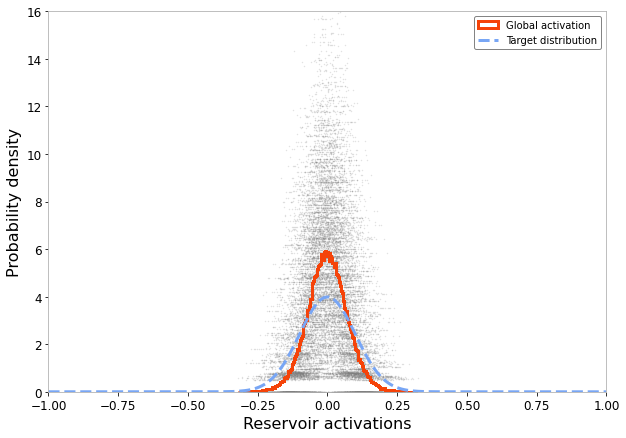

In [16]:
from scipy.stats import norm

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
ax1.set_xlim(-1.0, 1.0)
ax1.set_ylim(0, 16)
for s in range(states.shape[1]):
    hist, edges = np.histogram(states[:, s], density=True, bins=200)
    points = [np.mean([edges[i], edges[i+1]]) for i in range(len(edges) - 1)]
    ax1.scatter(points, hist, s=0.2, color="gray", alpha=0.25)
ax1.hist(states.flatten(), density=True, bins=200, histtype="step", label="Global activation", lw=3.0)

x = np.linspace(-1.0, 1.0, 200)
pdf = [bounded(norm, xi, 0.0, sigma, -1.0, 1.0) for xi in x]
ax1.plot(x, pdf, label="Target distribution", linestyle="--", lw=3.0)

ax1.set_xlabel("Reservoir activations")
ax1.set_ylabel("Probability density")
plt.legend()
plt.show()